In [1]:
import geopandas as gpd
import re
from geofeather import from_geofeather
from geofeather import to_geofeather

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster

from texttable import Texttable

In [3]:
from helper import *
from draw_maps import *
from main_logic import *
from debug import *
from loc_dict import *

In [408]:
pd.set_option('display.max_columns', None)

## Read data - Statewide

In [40]:
start_time = datetime.now()

parcel_whole = from_geofeather("data/ParcelData/statewide_parcel_data.feather")
address_whole = from_geofeather("data/AddressData/statewide_address_data.feather")

end_time = datetime.now()
print("Time cost: %.2fms" %((end_time - start_time).total_seconds() * 1000))

Time cost: 64357.50ms


In [41]:
parcel_style_whole_set = set(parcel_whole['STYLE'])

In [5]:
parcel_quincy = parcel_whole[parcel_whole['CITY'] == "QUINCY"]
address_quincy = address_whole[address_whole['COMMUNITY_NAME'] == "QUINCY"]

In [9]:
parcel_quincy = parcel_quincy.reset_index()
address_quincy = address_quincy.reset_index()

In [10]:
to_geofeather(parcel_quincy, "./data/test_data/quincy_parcel.feather")
to_geofeather(address_quincy, "./data/test_data/quincy_address.feather")

### Test area - for style

In [42]:
len(parcel_style_whole_set)

3476

In [93]:
def filter_out_style_by_keywords(style_set, keywords=["apt"], do_print=False):
    output = set()
    for v in style_set:
        for k in keywords:
            if k in v: 
                output.add(v)
                break
    print(len(output))
    if do_print:
        print(output)
    return output

def delete_from_set(style_set, not_desired_set):
    output = set()
    for v in style_set:
        if v not in not_desired_set: output.add(v)
    print(len(output))
    return output

In [75]:
parcel_style_whole_set = set([str(v).lower() for v in set(parcel_whole_res['STYLE'])])
len(parcel_style_whole_set)

1774

In [107]:
res_usecode_set_style_confidence = generate_residential_usecode_set({" " : usecode_desc['Style confidence']})
parcel_whole_res_style_confidence = benchmark(filter_out_residential_parcels, (parcel_whole, res_usecode_set_style_confidence))

Run time Cost is : 607.73ms


In [108]:
parcel_style_whole_set_style_confidence = set([str(v).lower() for v in set(parcel_whole_res_style_confidence['STYLE'])])
len(parcel_style_whole_set_style_confidence)

960

In [100]:
filter_out_style_by_keywords(parcel_style_whole_set_style_confidence, keywords=['cndo'])

0


set()

In [109]:
wanted_style_set = filter_out_style_by_keywords(parcel_style_whole_set_style_confidence, keywords=['apartment', 'apt', 'condo', 'fam', 'family', 'aprtmnt', 'flat', 'colonial', 'bungalow', 'bunglw', 'cottage', 'mobile', 'cndo', 'unit', 'units', 'cape'])
delete_from_set(parcel_style_whole_set_style_confidence, wanted_style_set)

273
687


{'0',
 '1',
 '1.5',
 '1.6',
 '1.65',
 '1.7',
 '1.75',
 '1.8',
 '1.85',
 '1.9',
 '12:duplex',
 '1:ranch',
 '2',
 '2 multi tnhs',
 '2-decker',
 '2.25',
 '2.3',
 '2.4',
 '2.5',
 '2f',
 '3',
 '3 decker',
 '3-decker',
 '4',
 '4:conv',
 '5:contemp',
 '6:dutch col',
 '6:ranch',
 '7:ranch slab',
 '8:raised ranch',
 '9',
 'accessory bldg',
 'accessorybld',
 'administrative bldg',
 'antique',
 'antique 1',
 'antique 3',
 'antique mix',
 'antique/olduni',
 'antique/victor',
 'antq-multi',
 'apartmnt-old',
 'aprtmt 4-8',
 'aq',
 'aq custom',
 'arena',
 'artist studio',
 'assist livin',
 'assistd livng',
 'assisted liv',
 'assisted living',
 'assisted living/ eld',
 'asst living',
 'asst lvg fclty',
 'at',
 'auto dealer',
 'auto dealr',
 'auto repair shop',
 'auto sales repa',
 'auto sales rpr',
 'auto sales/rpr',
 'auto supply/service',
 'b&b',
 'b&b/inn',
 'b+b/ inn',
 'b+b/inn',
 'bakery',
 'bank',
 'bank building',
 'bar',
 'bar/tavern',
 'bar/tavern/pub',
 'barbershop/salon',
 'barn',
 'barn/c

In [49]:
len(parcel_style_whole_set)

3165

### end test

## Read data - Test data

In [110]:
start_time = datetime.now()

parcel_quincy = from_geofeather("./data/test_data/quincy_parcel.feather")
address_quincy = from_geofeather("./data/test_data/quincy_address.feather")

end_time = datetime.now()
print("Time cost: %.2fms" %((end_time - start_time).total_seconds() * 1000))

Time cost: 792.67ms


### Read use code

In [111]:
state_use_code = gpd.read_file("data/state_use_codes_lookup_table/")

## Main process
### Clean addresses

In [169]:
def count_parcels(parcel_df, usecode_dict):
    id_ = []
    count_by_usecode = []
    usecode_str = []
    style_desc = []
    geometry_ = []
    area = []

    for loc_id_, df_ in parcel_df.groupby("LOC_ID"):
        # count_temp_style = 0
        style_set = set()
        for style_ in df_["STYLE"]:
            style_set.add(str(style_))
            # if style_ in usecode_dict.keys():
            #     count_temp += usecode_dict[style_]
        
        count_temp_usecode = 0
        usecode_set = set()
        for uc in df_["USE_CODE"]:
            usecode_set.add(str(uc))
            if uc and uc[:3] in usecode_dict.keys():
                count_temp_usecode += usecode_dict[uc[:3]]
            else:
                count_temp_usecode = -1

        id_.append(loc_id_)
        count_by_usecode.append(count_temp_usecode)
        style_desc.append(compose_string(style_set))
        usecode_str.append(compose_string(usecode_set))
        area.append(df_["SHAPE_AREA"].iloc[0])
        geometry_.append(df_['geometry'].iloc[0])

    return [id_, style_desc, count_by_usecode, usecode_str, area, geometry_]

In [112]:
address_quincy_afterdrop = benchmark(clean_addresses, (address_quincy))

Run time Cost is : 8716.65ms


### Filter out residential parcels

In [131]:
res_usecode_set = generate_residential_usecode_set(usecode_desc)

In [132]:
parcel_qunicy_residential = benchmark(filter_out_residential_parcels, (parcel_quincy, ["101", '102', '103', '104', '105', '109', '111', '112', '113', '114']))

Run time Cost is : 16.51ms


### Count by usecode

In [162]:
parcel_qunicy_residential_conv = parcel_qunicy_residential.to_crs("EPSG:4326")

In [170]:
res_quincy_parcel_test = benchmark(count_parcels, (parcel_qunicy_residential_conv, usecode_dict))

Run time Cost is : 8304.24ms


In [171]:
res_qunicy_parcel_aftercount = benchmark(generate_gpd_dataframe, (res_quincy_parcel_test, ["LOC_ID", "STYLE_DESC", "count_by_usecode", "usecode_str", "area"]))
res_qunicy_parcel_aftercount.head()

Run time Cost is : 26.01ms


,LOC_ID,STYLE_DESC,count_by_usecode,usecode_str,area,geometry
0,F_778027_2915235,Apartments,-1,1120,33452.339850,"POLYGON ((-71.04883 42.24728, -71.04863 42.246..."
1,F_779136_2914626,Colonial,1,1010,2501.946057,"POLYGON ((-71.04536 42.24488, -71.04596 42.244..."
2,F_779195_2914956,Colonial,1,1010,1059.174955,"POLYGON ((-71.04556 42.24579, -71.04575 42.245..."
3,F_779198_2916311,Colonial,1,1010,634.260808,"POLYGON ((-71.04553 42.24948, -71.04563 42.249..."
4,F_779220_2914717,Colonial,1,1010,925.200051,"POLYGON ((-71.04539 42.24508, -71.04539 42.245..."


In [273]:
address_quincy_loc.head()

,geometry
0,POINT (-71.03053 42.22899)
1,POINT (-71.03053 42.22899)
2,POINT (-71.03053 42.22899)
3,POINT (-71.03053 42.22899)
4,POINT (-71.02972 42.22912)


### Sjoin

In [410]:
address_quincy_loc_test = address_quincy_afterdrop.to_crs("EPSG:4326")
sjoin_not_count = gpd.sjoin(address_quincy_loc_test, res_qunicy_parcel_aftercount_conv, how="left", op="within")

In [426]:
## Duplicates!
## TODO: Problem, different address for same building
## TODO: How to solve?

In [425]:
sjoin_not_count[sjoin_not_count['LOC_ID'] == "F_784455_2921099"]

,index,CENTROID_ID,FULL_NUMBER_STANDARDIZED,ADDRESS_NUMBER_PREFIX,ADDRESS_NUMBER,ADDRESS_NUMBER_SUFFIX,ADDRESS_NUMBER_2_PREFIX,ADDRESS_NUMBER_2,ADDRESS_NUMBER_2_SUFFIX,STREET_NAME,FLOOR,UNIT,MASTER_ADDRESS_ID,STREET_NAME_ID,REL_LOC,SITE_ID,BUILDING_NAME,GEOGRAPHIC_TOWN_ID,COMMUNITY_ID,COMMUNITY_NAME,GEOGRAPHIC_TOWN,POSTCODE,PC_NAME,COUNTY,STATE,geometry,index_right,LOC_ID,STYLE_DESC,count_by_usecode,usecode_str,area
29168,2156026,M_239101_890354,243,None,243.0,None,None,NaN,None,NORTH CENTRAL AVENUE,None,1,4280998,180076,None,NaN,None,243.0,261,QUINCY,QUINCY,02170,QUINCY,NORFOLK,MA,POINT (-71.02608 42.26267),4208.0,F_784455_2921099,2 Fam Conver,2.0,1040,800.808293
29307,2156425,M_239101_890354,247,None,247.0,None,None,NaN,None,NORTH CENTRAL AVENUE,None,1,4385368,180076,None,NaN,None,243.0,261,QUINCY,QUINCY,02170,QUINCY,NORFOLK,MA,POINT (-71.02608 42.26267),4208.0,F_784455_2921099,2 Fam Conver,2.0,1040,800.808293
29309,2156427,M_239101_890354,247,None,247.0,None,None,NaN,None,NORTH CENTRAL AVENUE,None,2,4046650,180076,None,NaN,None,243.0,261,QUINCY,QUINCY,02170,QUINCY,NORFOLK,MA,POINT (-71.02608 42.26267),4208.0,F_784455_2921099,2 Fam Conver,2.0,1040,800.808293


In [412]:
address_quincy_loc = gpd.GeoDataFrame(address_quincy_afterdrop['geometry']).to_crs("EPSG:4326")
res_qunicy_parcel_aftercount_conv = res_qunicy_parcel_aftercount.set_crs(epsg=4326)

In [413]:
sjoin_test = benchmark(join_two_dataset, (address_quincy_loc, res_qunicy_parcel_aftercount_conv))

Run time Cost is : 2936.27ms


In [397]:
sjoin_test.head()

,index_left,LOC_ID,STYLE_DESC,count_by_usecode,usecode_str,area,geometry,ADD_COUNT
0,24712.0,F_778027_2915235,Apartments,-1,1120,33452.339850,"POLYGON ((-71.04883 42.24728, -71.04863 42.246...",2
1,9144.0,F_779136_2914626,Colonial,1,1010,2501.946057,"POLYGON ((-71.04536 42.24488, -71.04596 42.244...",1
2,26182.0,F_779195_2914956,Colonial,1,1010,1059.174955,"POLYGON ((-71.04556 42.24579, -71.04575 42.245...",1
3,19226.0,F_779198_2916311,Colonial,1,1010,634.260808,"POLYGON ((-71.04553 42.24948, -71.04563 42.249...",1
4,25852.0,F_779220_2914717,Colonial,1,1010,925.200051,"POLYGON ((-71.04539 42.24508, -71.04539 42.245...",1


### Merge two datasets

In [420]:
# No style yet
def filter_out_need_analysis(df, parcel_confidence_set, address_confidence_set):
    count_by_usecode = df['count_by_usecode']
    count_by_add = df['ADD_COUNT']
    usecode = df['usecode_str']

    assumption = []

    for i, u in enumerate(usecode):
        uu = u[:3]
        if uu in parcel_confidence_set:
            assumption.append(count_by_usecode[i])
            continue
        if uu in address_confidence_set:
            assumption.append(count_by_add[i])
            continue
        # TODO： possibile?
        # Two people live in a two family house?
        if count_by_add[i] < count_by_usecode[i]:
            assumption.append(count_by_add[i])
            continue
        if count_by_usecode[i] == count_by_add[i]:
            assumption.append(count_by_usecode[i])
            continue

        assumption.append(-1)
    return assumption

In [253]:
parcel_confidence_set = set(["102"])
address_confidence_set = set(["109", "111", "112", "113", "114"])

In [421]:
assumption_quincy_v1 = filter_out_need_analysis(sjoin_test, parcel_confidence_set, address_confidence_set)
sjoin_test['Assumption'] = assumption_quincy_v1

In [249]:
sjoin_test.head()

,index_left,STYLE_DESC,count_by_usecode,usecode_str,area,geometry,ADD_COUNT,Assumption
LOC_ID,,,,,,,,
F_778027_2915235,24712.0,Apartments,-1,1120,33452.339850,"POLYGON ((-71.04883 42.24728, -71.04863 42.246...",2,2
F_779136_2914626,9144.0,Colonial,1,1010,2501.946057,"POLYGON ((-71.04536 42.24488, -71.04596 42.244...",1,1
F_779195_2914956,26182.0,Colonial,1,1010,1059.174955,"POLYGON ((-71.04556 42.24579, -71.04575 42.245...",1,1
F_779198_2916311,19226.0,Colonial,1,1010,634.260808,"POLYGON ((-71.04553 42.24948, -71.04563 42.249...",1,1
F_779220_2914717,25852.0,Colonial,1,1010,925.200051,"POLYGON ((-71.04539 42.24508, -71.04539 42.245...",1,1


### Draw map

In [238]:
def add_polygons(polygons, m, popup_text = None, weights=None):
    # if not weights: weights = [-1] * len(polygons)
    for polygon, p, w in zip(polygons, popup_text, weights):
        try:
            geojson = folium.Choropleth(
                geo_data = polygon,
                fill_color = "#FF0000" if w == -1 else "#0000FF"
            )
            if p != "-1":
                folium.Popup(p, max_width=1000).add_to(geojson)
            geojson.add_to(m)
        except Exception as e:
            print(e)
            print(type(polygon))
            continue
def draw_debug_plot(points, polygons, weights_points=None, popup_polygons=None, weights_polygons=None):
    m = generateBaseMap()
    # add_points(points, m, weights_points)
    add_polygons(polygons, m, popup_polygons, weights_polygons)
    return m

In [243]:
sjoin_test.head()

,index_left,STYLE_DESC,count_by_usecode,usecode_str,area,geometry,ADD_COUNT,Assumption
LOC_ID,,,,,,,,
F_778027_2915235,24712.0,Apartments,-1,1120,33452.339850,"POLYGON ((-71.04883 42.24728, -71.04863 42.246...",2,-1
F_779136_2914626,9144.0,Colonial,1,1010,2501.946057,"POLYGON ((-71.04536 42.24488, -71.04596 42.244...",1,1
F_779195_2914956,26182.0,Colonial,1,1010,1059.174955,"POLYGON ((-71.04556 42.24579, -71.04575 42.245...",1,1
F_779198_2916311,19226.0,Colonial,1,1010,634.260808,"POLYGON ((-71.04553 42.24948, -71.04563 42.249...",1,1
F_779220_2914717,25852.0,Colonial,1,1010,925.200051,"POLYGON ((-71.04539 42.24508, -71.04539 42.245...",1,1


In [418]:
sjoin_test[sjoin_test["Assumption"]==-1]

,index_left,LOC_ID,STYLE_DESC,count_by_usecode,usecode_str,area,geometry,ADD_COUNT,Assumption
26,15253.0,F_779417_2915118,3 Fam Conv,3,1050,786.224984,"POLYGON ((-71.04481 42.24648, -71.04477 42.246...",2,-1
45,8933.0,F_779530_2914386,Colonial,2,1040,635.708076,"POLYGON ((-71.04419 42.24438, -71.04435 42.244...",4,-1
59,11305.0,F_779596_2914351,Family Duplex,2,1040,637.316424,"POLYGON ((-71.04394 42.24428, -71.04411 42.244...",1,-1
243,37567.0,F_780339_2923175,2 Fam Flat,2,1040,557.778776,"POLYGON ((-71.04105 42.26855, -71.04108 42.268...",1,-1
262,25288.0,F_780388_2914632,2 Fam Conver,2,1040,619.801733,"POLYGON ((-71.04127 42.24483, -71.04136 42.244...",1,-1
...,...,...,...,...,...,...,...,...,...
17862,48781.0,F_804860_2924209,Conventional,1,1015,308.230356,"POLYGON ((-70.95039 42.27089, -70.95040 42.270...",2,-1
17866,48787.0,F_804871_2924259,Conventional,2,1040,261.314268,"POLYGON ((-70.95037 42.27104, -70.95038 42.270...",1,-1
17872,40828.0,F_804886_2924375,Conventional,1,1010,383.997719,"POLYGON ((-70.95033 42.27126, -70.95033 42.271...",2,-1
17885,45683.0,F_804995_2925701,Conventional,1,1010,1256.944923,"POLYGON ((-70.94996 42.27489, -70.95034 42.274...",2,-1


In [259]:
# Generate popup text for maps
def generate_popup_text(sjoin_df):
    popup_text = []
    for id_, s, ac, uc, ucus, asump in zip(sjoin_df['LOC_ID'], sjoin_df['STYLE_DESC'], sjoin_df['ADD_COUNT'], sjoin_df['usecode_str'], sjoin_df['count_by_usecode'], sjoin_test['Assumption']):
        popup_text.append(id_ + "<br>" + s + "<br>Address count:" + str(ac) + "<br>USE CODE: " + str(uc) + "<br>Unit count - use code:" + str(ucus) + "<br>Final assumption:" + str(asump))
    return popup_text

In [422]:
test_agg_map = draw_debug_plot([], sjoin_test['geometry'], popup_polygons=generate_popup_text(sjoin_test), weights_polygons=sjoin_test['Assumption'])
test_agg_map.save('./maps/test_agg_map_quincy_v2.html')

### Distribution

In [427]:
anomaly_data = sjoin_test[sjoin_test['Assumption'] == -1]

In [431]:
len(anomaly_data)

318

In [434]:
set(zip(anomaly_data['ADD_COUNT'], anomaly_data['count_by_usecode']))

{(2, 1),
 (3, 1),
 (3, 2),
 (4, 1),
 (4, 2),
 (4, 3),
 (5, 1),
 (5, 2),
 (5, 3),
 (6, 2),
 (6, 3),
 (7, 3)}

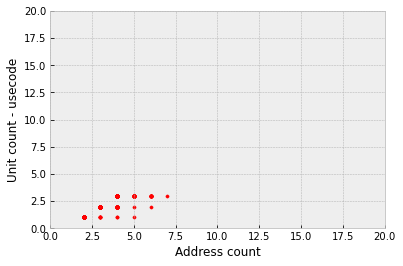

In [435]:
generate_distribution_map(anomaly_data['ADD_COUNT'], anomaly_data['count_by_usecode'], ["Address count", "Unit count - usecode"], filename="./pics/Output/add-usecode-anomaly.png", xlim=[0, 20], ylim=[0,20])

In [48]:
sjoin_test.head()

,index_left,UNIT_COUNT,STYLE,geometry,ADD_COUNT
LOC_ID,,,,,
F_775349_2913131,NaN,0,None,"POLYGON ((-71.05863 42.23951, -71.05916 42.239...",1
F_775713_2913360,NaN,0,None,"POLYGON ((-71.05697 42.24151, -71.05697 42.241...",1
F_776140_2913906,NaN,0,Pre-Eng Warehs,"POLYGON ((-71.05696 42.24151, -71.05696 42.241...",1
F_776785_2904919,283.0,0,Skating Arena,"MULTIPOLYGON (((-71.04710 42.22834, -71.04695 ...",2
F_777364_2914835,NaN,0,None,"POLYGON ((-71.04975 42.24545, -71.05294 42.243...",1


## Use code

In [13]:
filtered_use_code_0 = state_use_code[flter_list(state_use_code['USE_CODE'], pattern="^0")]
filtered_use_code_1 = state_use_code[flter_list(state_use_code['USE_CODE'], pattern="^1")]
filtered_use_code_9 = state_use_code[flter_list(state_use_code['USE_CODE'], pattern="^9")]

### USE CODE - Starts with 0
Classes

In [14]:
print_use_code_classes(filtered_use_code_0)

+----------+---------------------------------------------------+-------+-------+
| USE_CODE | USE_DESC                                          | COUNT | INDEX |
+----------+---------------------------------------------------+-------+-------+
| 000      | Use code not known or nor provided.               | 1     | 1     |
+----------+---------------------------------------------------+-------+-------+
| 007      | Mixed Use                                         | 1     | 2     |
+----------+---------------------------------------------------+-------+-------+
| 011      | Mixed Use-day care & residential                  | 1     | 3     |
+----------+---------------------------------------------------+-------+-------+
| 012      | Other                                             | 3     | 4     |
+----------+---------------------------------------------------+-------+-------+
| 013      | Mixed Use (Primarily Residential, some            | 1     | 5     |
|          | Commercial)    

Details

In [15]:
print_by_usecode(filtered_use_code_0)

+----------+---------------------------------------------------+-------+-------+
| USE_CODE | USE_DESC                                          | COUNT | INDEX |
+----------+---------------------------------------------------+-------+-------+
| 000      | Use code not known or nor provided.               | 1     | 1     |
+----------+---------------------------------------------------+-------+-------+
| 007      | Mixed Use                                         | 1     | 2     |
+----------+---------------------------------------------------+-------+-------+
| 0101     | Single Fam                                        | 100   | 3     |
+----------+---------------------------------------------------+-------+-------+
| 0102     | Condo                                             | 8     | 4     |
+----------+---------------------------------------------------+-------+-------+
| 0103     | Mobile Hom                                        | 13    | 5     |
+----------+----------------

### USE CODE - Starts with 1
Classes

In [16]:
print_use_code_classes(filtered_use_code_1)

+----------+---------------------------------------------------+-------+-------+
| USE_CODE | USE_DESC                                          | COUNT | INDEX |
+----------+---------------------------------------------------+-------+-------+
| 101      | Single Family Residential                         | 1     | 1     |
+----------+---------------------------------------------------+-------+-------+
| 102      | Residential Condominium                           | 1     | 2     |
+----------+---------------------------------------------------+-------+-------+
| 103      | Mobile Home (includes mobile home park land)      | 1     | 3     |
+----------+---------------------------------------------------+-------+-------+
| 104      | Two-Family Residential                            | 1     | 4     |
+----------+---------------------------------------------------+-------+-------+
| 105      | Three-Family Residential                          | 1     | 5     |
+----------+----------------

Details

In [17]:
print_by_usecode(filtered_use_code_1)

+----------+---------------------------------------------------+-------+-------+
| USE_CODE | USE_DESC                                          | COUNT | INDEX |
+----------+---------------------------------------------------+-------+-------+
| 1000     | Unknown [IMPUTED]                                 | 2     | 1     |
+----------+---------------------------------------------------+-------+-------+
| 1001     | Planned Development                               | 1     | 2     |
+----------+---------------------------------------------------+-------+-------+
| 101      | Single Family Residential                         | 1     | 3     |
+----------+---------------------------------------------------+-------+-------+
| 1010     | Single Family Residential                         | 1     | 4     |
+----------+---------------------------------------------------+-------+-------+
| 1011     | Single Family - NL                                | 23    | 5     |
+----------+----------------

### USE CODE - Starts with 9
Classes

In [18]:
print_use_code_classes(filtered_use_code_9)

+----------+---------------------------------------------------+-------+-------+
| USE_CODE | USE_DESC                                          | COUNT | INDEX |
+----------+---------------------------------------------------+-------+-------+
| 900      | United States Government                          | 1     | 1     |
+----------+---------------------------------------------------+-------+-------+
| 901      | (formerly Commonwealth of Massachusetts.  Removed | 1     | 2     |
|          | June 2009.)                                       |       |       |
+----------+---------------------------------------------------+-------+-------+
| 902      | (formerly Counties.  Removed June 2009.)          | 1     | 3     |
+----------+---------------------------------------------------+-------+-------+
| 903      | (formerly Municipalities/Districts.  Removed June | 1     | 4     |
|          | 2009.)                                            |       |       |
+----------+----------------

Details

In [19]:
print_by_usecode(filtered_use_code_9)

+----------+---------------------------------------------------+-------+-------+
| USE_CODE | USE_DESC                                          | COUNT | INDEX |
+----------+---------------------------------------------------+-------+-------+
| 900      | United States Government                          | 1     | 1     |
+----------+---------------------------------------------------+-------+-------+
| 9000     | United States Government                          | 1     | 2     |
+----------+---------------------------------------------------+-------+-------+
| 9001     | US GOVERNMENT - C                                 | 4     | 3     |
+----------+---------------------------------------------------+-------+-------+
| 9002     | US Govt C                                         | 2     | 4     |
+----------+---------------------------------------------------+-------+-------+
| 9003     | US Government                                     | 1     | 5     |
+----------+----------------

### Using statewise dataset

## Test section, Garbage for now

In [21]:
def construct_df_map(df, keyword="COMMUNITY_NAME"):
    m = {}
    for name, df in df.groupby(keyword):
        m.update({name: df})
    return m

In [22]:
address_cityname_df_map = construct_df_map(address_whole)

In [24]:
def join_two_dataset_state_map(parcel_df, address_df_map, keyword="CITY"):
    start_time = datetime.now()
    
    m = {}
    for name, p_df in parcel_df.groupby(keyword):
        start_time_2 = datetime.now()

        a_df = address_df_map[address_df_map["COMMUNITY_NAME"] == name]
        join_two_dataset_map(a_df, p_df, m, "LOC_ID")
        print("%s, cost: %.2dms" %(name, (datetime.now() - start_time_2).total_seconds() * 1000))
        print("res length: %d" %(len(m)))

    end_time = datetime.now()
    print("Time cost: %.2fms" %((end_time - start_time).total_seconds() * 1000))
    return m


In [110]:
gdf = gpd.GeoDataFrame()
print(gdf.empty)

True


In [101]:
parcel_whole.crs

<Projected CRS: EPSG:26986>
Name: NAD83 / Massachusetts Mainland
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - Massachusetts onshore - counties of Barnstable; Berkshire; Bristol; Essex; Franklin; Hampden; Hampshire; Middlesex; Norfolk; Plymouth; Suffolk; Worcester.
- bounds: (-73.5, 41.46, -69.86, 42.89)
Coordinate Operation:
- name: SPCS83 Massachusetts Mainland zone (meters)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [18]:
def join_state_data(address_whole, parcel_whole):
    start_time = datetime.now()
    res = join_two_dataset(address_whole, parcel_whole, "LOC_ID")
    end_time = datetime.now()
    print("Time cost: %.2fms" %((end_time - start_time).total_seconds() * 1000))
    return res

In [20]:
joined_state_1 = join_state_data(address_whole, parcel_whole)

Time cost: 4064548.05ms


In [23]:
to_geofeather(joined_state_1.reset_index(), "./data/processed.feather")

In [24]:
len(joined_state_1.index)

1834283

In [27]:
joined_state_1_conv = joined_state_1.to_crs("EPSG:4326")
mass_heat_map = draw_debug_heatmap(joined_state_1_conv.geometry, joined_state_1_conv.ADD_COUNT, 12)
mass_heat_map.save("./maps/mass_heatmap.html")

In [ ]:
joined_state_2 = join_two_dataset_state_map(parcel_whole, address_whole)

ABINGTON, cost: 2718ms
res length: 4475
ACTON, cost: 3823ms
res length: 10786
ACUSHNET, cost: 2239ms
res length: 14434
ADAMS, cost: 1884ms
res length: 17384
AGAWAM, cost: 5109ms
res length: 25982
ALFORD, cost: 363ms
res length: 26321
AMESBURY, cost: 3005ms
res length: 31120
AMHERST, cost: 3311ms
res length: 36022
ANDOVER, cost: 6095ms
res length: 45979
AQUINNAH, cost: 486ms
res length: 46504
ARLINGTON, cost: 7261ms
res length: 58019
ASHBURNHAM, cost: 1697ms
res length: 60626
ASHBY, cost: 851ms
res length: 61827
ASHFIELD, cost: 648ms
res length: 62639
ASHLAND, cost: 2706ms
res length: 66887
ATHOL, cost: 2510ms
res length: 70856
ATTLEBORO, cost: 7412ms
res length: 82810
AUBURN, cost: 3524ms
res length: 88632
AVON, cost: 1063ms
res length: 90218
AYER, cost: 1509ms
res length: 92402
BARNSTABLE, cost: 2827ms
res length: 94399
BARRE, cost: 1337ms
res length: 96268
BECKET, cost: 1337ms
res length: 98088
BEDFORD, cost: 2585ms
res length: 102232
BELCHERTOWN, cost: 3106ms
res length: 107138
BELL

In [23]:
address_whole.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3656134 entries, 0 to 3656133
Data columns (total 25 columns):
 #   Column                    Dtype   
---  ------                    -----   
 0   CENTROID_ID               object  
 1   FULL_NUMBER_STANDARDIZED  object  
 2   ADDRESS_NUMBER_PREFIX     object  
 3   ADDRESS_NUMBER            float64 
 4   ADDRESS_NUMBER_SUFFIX     object  
 5   ADDRESS_NUMBER_2_PREFIX   object  
 6   ADDRESS_NUMBER_2          float64 
 7   ADDRESS_NUMBER_2_SUFFIX   object  
 8   STREET_NAME               object  
 9   FLOOR                     object  
 10  UNIT                      object  
 11  MASTER_ADDRESS_ID         int64   
 12  STREET_NAME_ID            int64   
 13  REL_LOC                   object  
 14  SITE_ID                   float64 
 15  BUILDING_NAME             object  
 16  GEOGRAPHIC_TOWN_ID        float64 
 17  COMMUNITY_ID              int64   
 18  COMMUNITY_NAME            object  
 19  GEOGRAPHIC_TOWN           object  

### Using Quincy dataset

In [12]:
#Merge using goepandas.sjoin
start_time = datetime.now()

joined_test_quincy_2k = gpd.sjoin(address_quincy, parcel_quincy_test_2k, how="inner", op="within")
# newQuincy = gpd.sjoin(address_quincy, parcel_quincy[['LOC_ID', 'geometry']], how='left', op='within')
# joined_test = gpd.sjoin(parcel_quincy_converted, address_quincy_converted, how="inner", op="within")

end_time = datetime.now()
print("Time cost: %.2fms" %((end_time - start_time).total_seconds() * 1000))

Time cost: 291.07ms


In [14]:
parcel_quincy_test_2k_conv = parcel_quincy_test_2k.to_crs("EPSG:4326")
joined_test_quincy_2k_conv = joined_test_quincy_2k.to_crs("EPSG:4326")

In [19]:
joined_test_quincy_2k_conv.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3458 entries, 2120189 to 2225326
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   CENTROID_ID               3458 non-null   object  
 1   FULL_NUMBER_STANDARDIZED  3458 non-null   object  
 2   ADDRESS_NUMBER_PREFIX     1 non-null      object  
 3   ADDRESS_NUMBER            3458 non-null   float64 
 4   ADDRESS_NUMBER_SUFFIX     22 non-null     object  
 5   ADDRESS_NUMBER_2_PREFIX   0 non-null      object  
 6   ADDRESS_NUMBER_2          0 non-null      float64 
 7   ADDRESS_NUMBER_2_SUFFIX   0 non-null      object  
 8   STREET_NAME               3458 non-null   object  
 9   FLOOR                     0 non-null      object  
 10  UNIT                      1167 non-null   object  
 11  MASTER_ADDRESS_ID         3458 non-null   int64   
 12  STREET_NAME_ID            3458 non-null   int64   
 13  REL_LOC                   1 non

In [16]:
test_m_1 = draw_debug_plot(joined_test_quincy_2k_conv.geometry, parcel_quincy_test_2k_conv.geometry)

In [18]:
test_m_1.save("maps/test_m_1.html")

In [65]:
test_drop = parcel_quincy_2k.drop_duplicates(["MAP_PAR_ID"])

In [67]:
test_drop.MAP_PAR_ID.value_counts()

5190-22-A       1
5012-10-555     1
5056-61-760     1
4001-27-        1
6154-62-42      1
               ..
1168-44-C       1
6018-25-A       1
1033-20-76      1
4125-17-14      1
6017B-26-235    1
Name: MAP_PAR_ID, Length: 1308, dtype: int64

In [32]:
parcel_quincy.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 24247 entries, 207 to 2406350
Data columns (total 47 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   MAP_PAR_ID  17102 non-null  object  
 1   LOC_ID      24247 non-null  object  
 2   POLY_TYPE   24247 non-null  object  
 3   MAP_NO      24241 non-null  object  
 4   SOURCE      24247 non-null  object  
 5   PLAN_ID     0 non-null      object  
 6   LAST_EDIT   24247 non-null  int64   
 7   BND_CHK     143 non-null    object  
 8   NO_MATCH    24247 non-null  object  
 9   TOWN_ID     24247 non-null  int64   
 10  PROP_ID     24247 non-null  object  
 11  BLDG_VAL    24247 non-null  int64   
 12  LAND_VAL    24247 non-null  int64   
 13  OTHER_VAL   24247 non-null  int64   
 14  TOTAL_VAL   24247 non-null  int64   
 15  FY          24247 non-null  int64   
 16  LOT_SIZE    24247 non-null  float64 
 17  LS_DATE     24247 non-null  object  
 18  LS_PRICE    24247 non-null  int64 

In [59]:
parcel_quincy_2k = parcel_quincy[:2000]

In [68]:
#Merge using goepandas.sjoin
start_time = datetime.now()

# joined_quincy_2k = gpd.sjoin(address_quincy, parcel_quincy_2k, how="inner", op="within")
joined_quincy_2k = gpd.sjoin(address_quincy, test_drop, how="inner", op="within")

end_time = datetime.now()
print("Time cost: %.2fms" %((end_time - start_time).total_seconds() * 1000))

Time cost: 266.06ms


In [80]:
joined_quincy_2k_count = count_address(joined_quincy_2k)

In [69]:
joined_quincy_2k.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5137 entries, 2065885 to 2303588
Data columns (total 72 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   CENTROID_ID               5137 non-null   object  
 1   FULL_NUMBER_STANDARDIZED  5137 non-null   object  
 2   ADDRESS_NUMBER_PREFIX     1 non-null      object  
 3   ADDRESS_NUMBER            5137 non-null   float64 
 4   ADDRESS_NUMBER_SUFFIX     17 non-null     object  
 5   ADDRESS_NUMBER_2_PREFIX   0 non-null      object  
 6   ADDRESS_NUMBER_2          0 non-null      float64 
 7   ADDRESS_NUMBER_2_SUFFIX   0 non-null      object  
 8   STREET_NAME               5137 non-null   object  
 9   FLOOR                     0 non-null      object  
 10  UNIT                      3233 non-null   object  
 11  MASTER_ADDRESS_ID         5137 non-null   int64   
 12  STREET_NAME_ID            5137 non-null   int64   
 13  REL_LOC                   0 non

In [83]:
joined_quincy_2k_count_conv = joined_quincy_2k_count.to_crs("EPSG:4326")
test_drop_conv = test_drop.to_crs("EPSG:4326")

In [91]:
test_m_2 = draw_debug_plot(joined_quincy_2k_count_conv.geometry, test_drop_conv.geometry, joined_quincy_2k_count_conv.ADD_COUNT)
test_m_2.save("./maps/test_m_2.html")

In [100]:
parcel_quincy_conv = parcel_quincy.to_crs("EPSG:4326")
test_m_3 = draw_debug_plot([], parcel_quincy_conv.geometry)
test_m_3.save("./maps/quincy_parcel.html")

In [35]:
len(address_quincy[address_quincy["CENTROID_ID"] == "M_242902_889211"])

410

In [53]:
observe_data = parcel_quincy_2k[parcel_quincy_2k["MAP_PAR_ID"] == "4032-20-16MGT"]

In [50]:
# count polygons with same MAP_PAR_ID
def count_polygons(polygons):
    p = None
    count = 1
    for polygon in polygons:
        if not p:
            p = polygon
            continue
        if p != polygon:
            p = polygon
            count += 1
    print(count)

In [54]:
count_polygons(observe_data.geometry)

1


### Whole quincy

In [114]:
quincy_join = join_two_dataset(address_quincy, parcel_quincy)

Time cost: 2224.01ms


In [118]:
calculate_coverage(quincy_join, parcel_quincy.drop_duplicates("MAP_PAR_ID"))

97.79

In [117]:
quincy_join.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 15315 entries, 1002-1-103 to 6171-24-ML20B
Data columns (total 72 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   CENTROID_ID               15315 non-null  object  
 1   FULL_NUMBER_STANDARDIZED  15315 non-null  object  
 2   ADDRESS_NUMBER_PREFIX     5 non-null      object  
 3   ADDRESS_NUMBER            15315 non-null  float64 
 4   ADDRESS_NUMBER_SUFFIX     106 non-null    object  
 5   ADDRESS_NUMBER_2_PREFIX   0 non-null      object  
 6   ADDRESS_NUMBER_2          0 non-null      float64 
 7   ADDRESS_NUMBER_2_SUFFIX   0 non-null      object  
 8   STREET_NAME               15315 non-null  object  
 9   FLOOR                     0 non-null      object  
 10  UNIT                      2037 non-null   object  
 11  MASTER_ADDRESS_ID         15315 non-null  int64   
 12  STREET_NAME_ID            15315 non-null  int64   
 13  REL_LOC                   

In [119]:
quincy_join_conv = quincy_join.to_crs("EPSG:4326")

In [25]:
quincy_heat_map = draw_debug_heatmap(joined_state_1.geometry, joined_state_1.ADD_COUNT, 15)
quincy_heat_map.save("./maps/mass_heatmap.html")